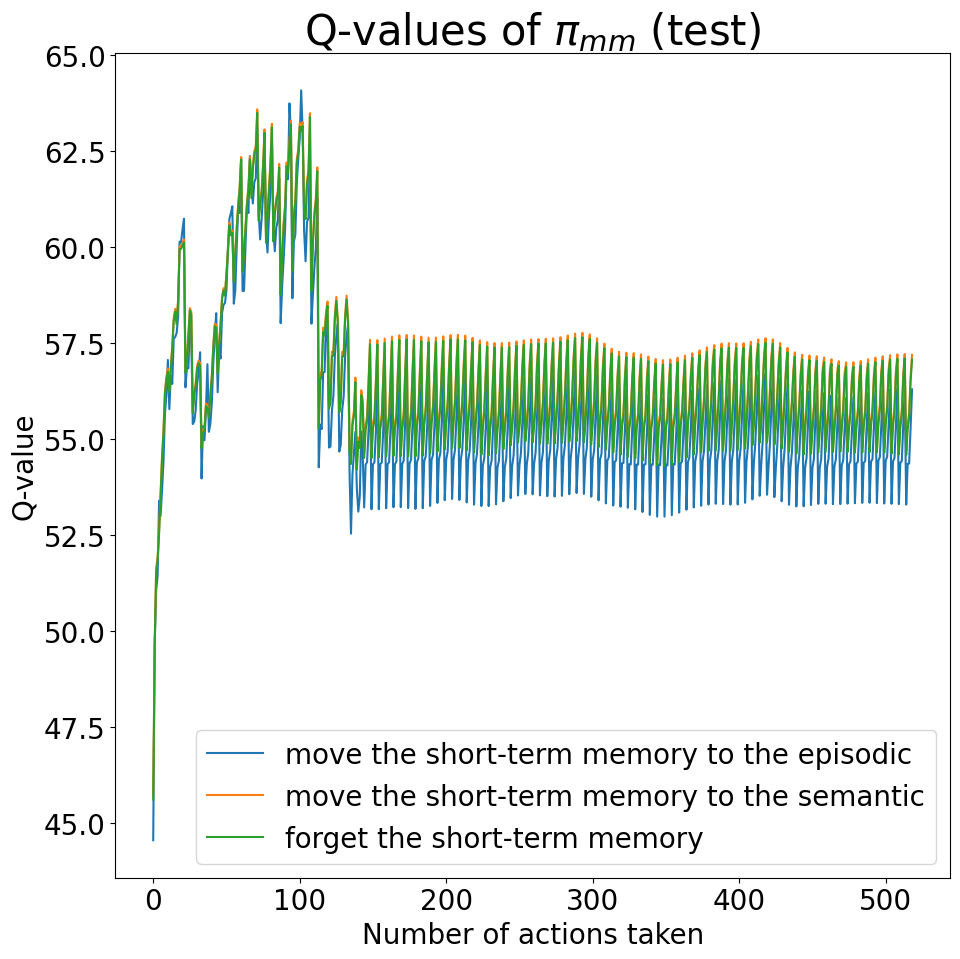

In [159]:
from explicit_memory.utils import read_pickle

agent = read_pickle(
    "./trained-agents/lstm-mm/2023-12-28 18:13:03.001952/agent.pkl"
)

import matplotlib.pyplot as plt
import numpy as np

# Updating font size
new_font_size = 20
plt.rcParams.update(
    {"font.size": new_font_size}
)  # Update default font size for all elements


plt.figure(figsize=(10, 10))
labels = [
    "move the short-term memory to the episodic",
    "move the short-term memory to the semantic",
    "forget the short-term memory",
]

plt.title("Q-values of $\pi_{mm}$ (test)", fontsize=new_font_size+10)
for action_number in range(len(agent.q_values["test"][0])):
    plt.plot(
        [q_values_[action_number] for q_values_ in agent.q_values["test"]],
        label=labels[action_number],
    )
plt.legend(loc="lower right", fontsize=new_font_size)
plt.xlabel("Number of actions taken", fontsize=new_font_size)
plt.ylabel("Q-value", fontsize=new_font_size)
plt.tight_layout()
plt.savefig("q-values-test-mm.pdf")
plt.show()

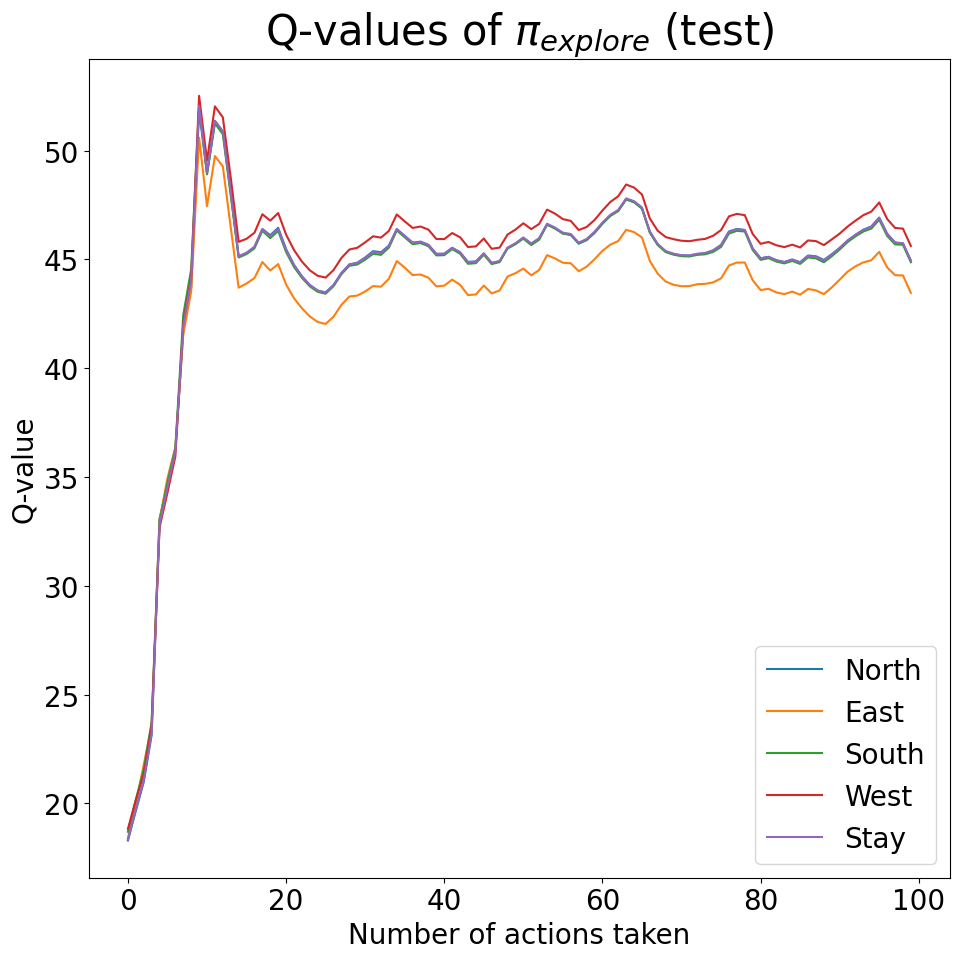

In [160]:
from explicit_memory.utils import read_pickle
import matplotlib.pyplot as plt
import numpy as np

agent = read_pickle(
    "./trained-agents/lstm-explore/2024-01-06 20:04:03.511403/agent.pkl"
)

# Updating font size
new_font_size = 20
plt.rcParams.update(
    {"font.size": new_font_size}
)  # Update default font size for all elements


plt.figure(figsize=(10, 10))
labels = [
    "North", "East", "South", "West", "Stay"
]


plt.title("Q-values of $\pi_{explore}$ (test)", fontsize=new_font_size+10)
for action_number in range(len(agent.q_values["test"][0])):
    plt.plot(
        [q_values_[action_number] for q_values_ in agent.q_values["test"]],
        label=labels[action_number],
    )
plt.legend(loc="lower right", fontsize=new_font_size)
plt.xlabel("Number of actions taken", fontsize=new_font_size)
plt.ylabel("Q-value", fontsize=new_font_size)
plt.tight_layout()
plt.savefig("q-values-test-explore.pdf")
plt.show()


In [72]:
agent.mm_policy_model.word2idx

{'<PAD>': 0,
 'sta_000': 1,
 'sta_001': 2,
 'sta_002': 3,
 'sta_003': 4,
 'ind_000': 5,
 'ind_001': 6,
 'ind_002': 7,
 'ind_003': 8,
 'dep_000': 9,
 'dep_001': 10,
 'dep_002': 11,
 'dep_003': 12,
 'agent': 13,
 'room_000': 14,
 'room_001': 15,
 'room_002': 16,
 'room_003': 17,
 'room_004': 18,
 'room_005': 19,
 'room_006': 20,
 'room_007': 21,
 'room_008': 22,
 'room_009': 23,
 'room_010': 24,
 'room_011': 25,
 'room_012': 26,
 'room_013': 27,
 'room_014': 28,
 'room_015': 29,
 'wall': 30,
 'north': 31,
 'east': 32,
 'south': 33,
 'west': 34,
 'atlocation': 35}

In [63]:
import torch
import numpy as np

np_vectors = []

for word in agent.mm_policy_model.word2idx:
    if word == "<PAD>":
        continue
    vec = (
        agent.mm_policy_model.embeddings(
            torch.tensor(agent.mm_policy_model.word2idx[word])
        )
        .detach()
        .cpu()
        .numpy()
    )
    np_vectors.append(vec)

In [73]:
len(np_vectors)

35

In [74]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA analysis
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(np_vectors)

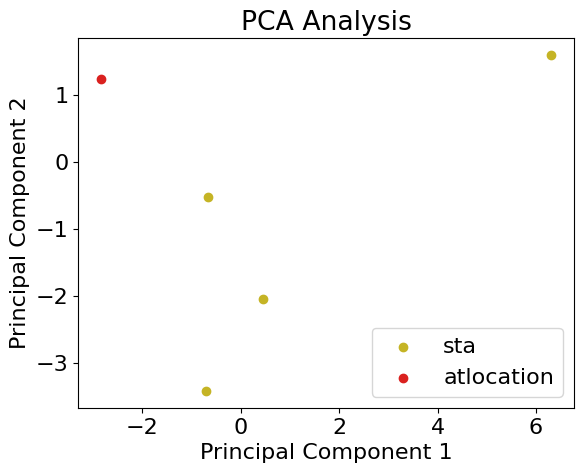

In [103]:
import random

# Generate random colors
colors = ["#" + "".join(random.choices("0123456789ABCDEF", k=6))
          for _ in range(10)]

# Plot the projected data with random colors
plt.scatter(pca_vectors[0:4, 0], pca_vectors[0:4, 1],
            color=colors[0], label="sta")

# plt.scatter(pca_vectors[4:8, 0], pca_vectors[4:8, 1],
#             color=colors[1], label="ind")

# plt.scatter(pca_vectors[8:12, 0], pca_vectors[8:12, 1],
#             color=colors[2], label="dep")

# plt.scatter(pca_vectors[12, 0], pca_vectors[12, 1],
#             color=colors[3], label="agent")

# plt.scatter(pca_vectors[13:29, 0], pca_vectors[13:29, 1],
#             color=colors[4], label="room")

# plt.scatter(pca_vectors[29, 0], pca_vectors[29, 1],
#             color=colors[5], label="wall")

# plt.scatter(pca_vectors[30:34, 0], pca_vectors[30:34, 1],
#             color=colors[6], label="nesw")

plt.scatter(pca_vectors[34, 0], pca_vectors[34, 1],
            color=colors[7], label="atlocation")


plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Analysis")
plt.legend()
plt.show()

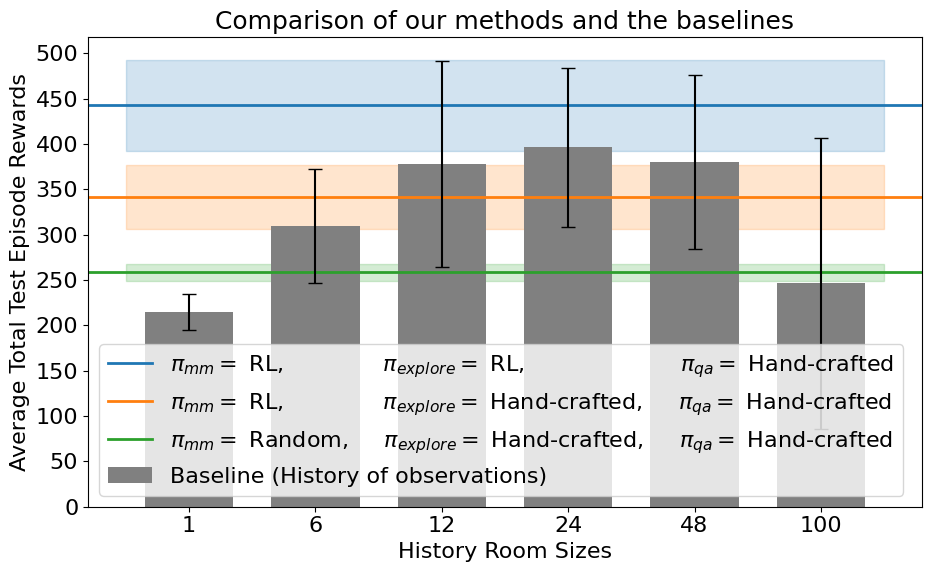

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Updating font size
new_font_size = 16
plt.rcParams.update(
    {"font.size": new_font_size}
)  # Update default font size for all elements

# Data for the plot
our_method_names = [
    "$\pi_{mm} =$ RL,              $\pi_{explore} =$ RL,                      $\pi_{qa} =$ Hand-crafted",
    "$\pi_{mm} =$ RL,              $\pi_{explore} =$ Hand-crafted,     $\pi_{qa} =$ Hand-crafted",
    "$\pi_{mm} =$ Random,     $\pi_{explore} =$ Hand-crafted,     $\pi_{qa} =$ Hand-crafted",
]

our_method_rewards = [258.51, 341.7, 442.7][::-1]
our_method_errors = [9.17, 34.94, 50.45][::-1]
history_sizes = [1, 6, 12, 24, 48, 100]
history_rewards = [214.94, 309.62, 377.94, 396.43, 379.97, 246.26]
history_errors = [19.94, 63.30, 113.98, 87.84, 95.76, 160.85]

# Updated colors for a more professional look
method_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green

plt.figure(figsize=(10, 6))

# Horizontal lines for 'Our method' with different colors
for i, (reward, error, color) in enumerate(
    zip(our_method_rewards, our_method_errors, method_colors)
):
    plt.axhline(
        y=reward, color=color, linestyle="-", linewidth=2, label=our_method_names[i]
    )
    plt.fill_between(
        np.linspace(-0.5, len(history_sizes) - 0.5, 500),
        reward - error,
        reward + error,
        color=color,
        alpha=0.2,
    )

# Bar chart for 'Baseline (History)'
bar_width = 0.7  # width of the bars
bar_positions = np.arange(len(history_sizes))  # positions for the bars
plt.bar(
    bar_positions,
    history_rewards,
    width=bar_width,
    yerr=history_errors,
    capsize=5,
    color="gray",
    label="Baseline (History of observations)",
)  # Red for baseline

# Setting the x-axis labels to only show history room sizes
plt.xticks(bar_positions, list(map(str, history_sizes)), rotation=0)

# Fine-tuning the y-axis
y_min, y_max = 0, 530
plt.yticks(np.arange(y_min, y_max, 50), fontsize=new_font_size)

plt.xlabel("History Room Sizes", fontsize=new_font_size)
plt.ylabel("Average Total Test Episode Rewards", fontsize=new_font_size)
plt.title("Comparison of our methods and the baselines",
          fontsize=new_font_size + 2)

plt.legend(loc="lower left", fontsize=new_font_size)
plt.tight_layout()

plt.savefig("final-results.pdf")
plt.show()

In [29]:
from glob import glob
from explicit_memory.utils import read_yaml, read_pickle
import pandas as pd

table = {1: [], 6: [], 10: [], 12: [], 24: [], 48: [], 50: [], 100: []}
for results_path in sorted(
    glob("./training_results/baselines/dqn_lstm/*/*/results.yaml")
):
    train_path = results_path.replace("results.yaml", "train.yaml")
    handcrafted_path = results_path.replace("results.yaml", "handcrafted.yaml")

    results = read_yaml(results_path)
    train = read_yaml(train_path)
    handcrafted = read_yaml(handcrafted_path)

    test_score = results["test_score"]
    sorted_val = sorted(results["validation_score"], key=lambda x: x["mean"])
    val_score = sorted_val[-1]

    try:
        table[train["history_block_size"]].append(
            {
                "test_mean": test_score["mean"],
                "test_std": test_score["std"],
                "val_mean": val_score["mean"],
                "val_std": val_score["std"],
                # "gamma": train["gamma"],
                # "pretrain_semantic": train["pretrain_semantic"],
                "batch_size": train["batch_size"],
                "dir": results_path.split("/")[-2],
                "test_seed": train["test_seed"],
                # "target_update_interval": train["target_update_interval"],
                # "mm_agent_path": train["mm_agent_path"].split("/")[-2],
                # "question_interval": train["env_config"]["question_interval"],
                # "num_iterations": train["num_iterations"],
                # "replay_buffer_size": train["replay_buffer_size"],
                # "warm_start": train["warm_start"],
                # "batch_size": train["batch_size"],
                "handcrafted_random": handcrafted["random"]["mean"],
                "handcrafted_random_std": handcrafted["random"]["std"],
                "handcrafted_avoid_walls": handcrafted["avoid_walls"]["mean"],
                "handcrafted_avoid_walls_std": handcrafted["avoid_walls"]["std"],
            }
        )
    except Exception as e:
        print(e)
        pass

table[train["history_block_size"]] = sorted(
    table[train["history_block_size"]], key=lambda x: x["test_mean"], reverse=True
)
table = pd.DataFrame(table[24])
table

,test_mean,test_std,val_mean,val_std,batch_size,dir,test_seed,handcrafted_random,handcrafted_random_std,handcrafted_avoid_walls,handcrafted_avoid_walls_std
0,297.4,76.88,300.9,62.07,32,2024-01-12 08:30:01.676969,1,272.8,74.703146,385.8,133.211711
1,405.3,88.61,453.7,123.25,32,2024-01-12 08:30:01.696979,0,272.8,74.703146,385.8,133.211711
2,362.8,85.86,441.3,88.33,32,2024-01-12 12:28:11.553673,2,272.8,74.703146,385.8,133.211711
3,380.3,122.88,433.2,105.74,32,2024-01-12 12:28:11.586054,3,272.8,74.703146,385.8,133.211711
4,536.4,27.54,556.1,53.14,32,2024-01-12 16:33:47.771934,4,272.8,74.703146,385.8,133.211711


In [30]:
table.val_mean.mean(), table.val_mean.std(
), table.test_mean.mean(), table.test_mean.std()

(437.03999999999996, 90.85679941534372, 396.43999999999994, 87.84698628865989)

In [32]:
from glob import glob
from explicit_memory.utils import read_yaml
import pandas as pd

table = {"l": {8: [], 16: []}, "l2": {8: [], 16: []}}
for results_path in sorted(glob("./training_results/explore/LSTM/*/results.yaml")):
    train_path = results_path.replace("results.yaml", "train.yaml")
    handcrafted_path = results_path.replace("results.yaml", "handcrafted.yaml")

    results = read_yaml(results_path)
    train = read_yaml(train_path)
    handcrafted = read_yaml(handcrafted_path)
    print(handcrafted)

    test_score = results["test_score"]
    sorted_val = sorted(results["validation_score"], key=lambda x: x["mean"])
    val_score = sorted_val[-1]

    try:
        table[train["env_config"]["room_size"]][train["capacity"]["episodic"]].append(
            {
                "test_mean": test_score["mean"],
                "test_std": test_score["std"],
                "val_mean": val_score["mean"],
                "val_std": val_score["std"],
                "gamma": train["gamma"],
                # "pretrain_semantic": train["pretrain_semantic"],
                "batch_size": train["batch_size"],
                "dir": results_path.split("/")[-2],
                "test_seed": train["test_seed"],
                # "target_update_interval": train["target_update_interval"],
                # "mm_agent_path": train["mm_agent_path"].split("/")[-2],
                "question_interval": train["env_config"]["question_interval"],
                "num_iterations": train["num_iterations"],
                "replay_buffer_size": train["replay_buffer_size"],
                "warm_start": train["warm_start"],
                # "batch_size": train["batch_size"],
            }
        )
    except Exception as e:
        print(e)
        pass

for room_size in ["l", "l2"]:
    for capacity in [8, 16]:
        table[room_size][capacity] = sorted(
            table[room_size][capacity], key=lambda x: x["test_mean"], reverse=True
        )
table = pd.DataFrame([foo for foo in table["l"][16]])
table

{"{'mm': 'random', 'qa': 'episodic_semantic', 'explore': 'random', 'pretrain_semantic': False}": {'mean': 194.83999999999997, 'std': 33.17701614069596}, "{'mm': 'random', 'qa': 'episodic_semantic', 'explore': 'random', 'pretrain_semantic': 'exclude_walls'}": {'mean': 169.64000000000001, 'std': 27.55166782610446}, "{'mm': 'random', 'qa': 'episodic_semantic', 'explore': 'avoid_walls', 'pretrain_semantic': False}": {'mean': 229.88000000000002, 'std': 20.080776877401938}, "{'mm': 'random', 'qa': 'episodic_semantic', 'explore': 'avoid_walls', 'pretrain_semantic': 'exclude_walls'}": {'mean': 188.90000000000003, 'std': 25.527632087602644}, "{'mm': 'episodic', 'qa': 'episodic_semantic', 'explore': 'random', 'pretrain_semantic': False}": {'mean': 97.32000000000001, 'std': 8.730956419545342}, "{'mm': 'episodic', 'qa': 'episodic_semantic', 'explore': 'random', 'pretrain_semantic': 'exclude_walls'}": {'mean': 97.32000000000001, 'std': 8.730956419545342}, "{'mm': 'episodic', 'qa': 'episodic_semanti

,test_mean,test_std,val_mean,val_std,gamma,batch_size,dir,test_seed,question_interval,num_iterations,replay_buffer_size,warm_start
0,498.1,42.67,493.9,47.72,0.9,32,2024-01-06 20:04:03.511403,4,1,10000,10000,1000.0
1,493.5,59.58,464.0,94.01,0.9,32,2024-01-06 18:30:33.902768,3,1,10000,10000,1000.0
2,424.9,68.14,423.3,67.95,0.9,32,2024-01-06 20:04:03.478466,0,1,10000,10000,1000.0
3,410.9,67.66,450.4,53.21,0.9,32,2024-01-06 20:56:13.768621,2,1,10000,10000,1000.0
4,386.1,78.48,421.0,58.35,0.9,32,2024-01-06 18:30:33.955283,1,1,10000,10000,1000.0


In [33]:
table.val_mean.mean(), table.val_mean.std(
), table.test_mean.mean(), table.test_mean.std()

(450.52, 30.314633430077944, 442.7, 50.451560927289464)

In [ ]:
from explicit_memory.visualize_results import save_figs_and_memories

save_figs_and_memories(
    agent_dir="./trained-agents/lstm-explore/2024-01-06 20:04:03.511403/",
    mm_policy="neural",
    qa_policy="episodic_semantic",
    explore_policy="neural",
    test_seed=1,
)

In [ ]:
from glob import glob
from explicit_memory.utils import read_yaml
import pandas as pd

table = {"l": {8: [], 16: []}, "l2": {8: [], 16: []}}
for results_path in sorted(glob("./training_results/mm/LSTM/*/results.yaml")):
    train_path = results_path.replace("results.yaml", "train.yaml")

    results = read_yaml(results_path)
    train = read_yaml(train_path)

    test_score = results["test_score"]
    sorted_val = sorted(results["validation_score"], key=lambda x: x["mean"])
    val_score = sorted_val[-1]

    try:
        table[train["env_config"]["room_size"]][train["capacity"]["episodic"]].append(
            {
                "test_mean": test_score["mean"],
                "test_std": test_score["std"],
                "val_mean": val_score["mean"],
                "val_std": val_score["std"],
                "gamma": train["gamma"],
                # "pretrain_semantic": train["pretrain_semantic"],
                "batch_size": train["batch_size"],
                "dir": results_path.split("/")[-2],
                "test_seed": train["test_seed"],
            }
        )
    except KeyError:
        pass

for room_size in ["l", "l2"]:
    for capacity in [8, 16]:
        table[room_size][capacity] = sorted(
            table[room_size][capacity], key=lambda x: x["test_mean"], reverse=True
        )

In [ ]:
pd.DataFrame([foo for foo in table["l"][16]])

In [ ]:
pd.DataFrame([foo for foo in table["l"][16]]).test_mean.mean(), pd.DataFrame(
    [foo for foo in table["l"][16]]
).test_mean.std()

In [ ]:
pd.DataFrame([foo for foo in table["l"][16]]).val_mean.mean(), pd.DataFrame(
    [foo for foo in table["l"][16]]
).val_mean.std()